In [ ]:
# Based on R code by Elsa Arcaute

In [57]:
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram
import cairo

% matplotlib inline

# Networkx

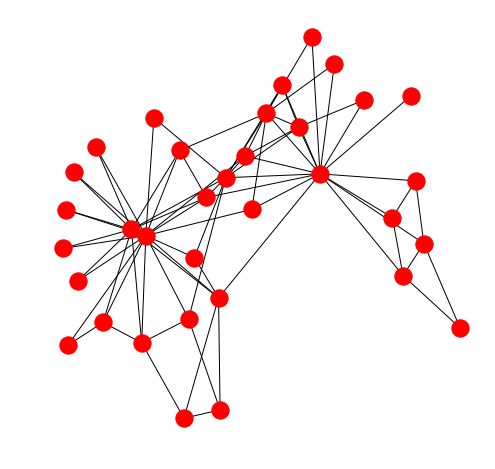

In [46]:
# Get the karate club graph
g_karate = nx.karate_club_graph()

# Have a look at it!
f, ax = plt.subplots(figsize = (8,8))
nx.draw(g_karate, ax=ax)

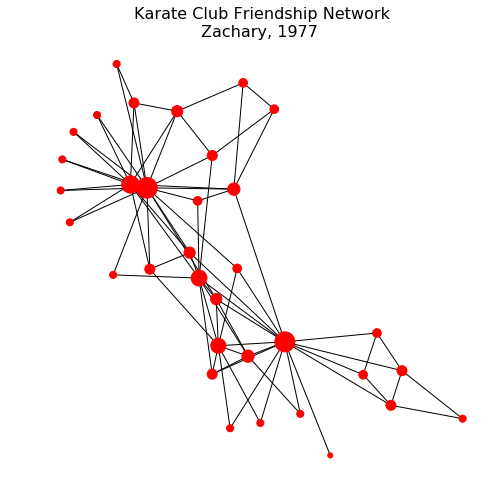

In [3]:
#let us now produce a plot such that the nodes in the plot have a size related to their degree
# Have a look at it!
f, ax = plt.subplots(figsize = (8,8))
nx.draw(g_karate, node_size = [d*25 for i,d in g_karate.degree()], ax=ax)
ax.set_title('Karate Club Friendship Network\nZachary, 1977 ', fontsize = 16);

# Girvan - Newman

In [45]:
# Girvan-Newman algorithm
# This provides all subgraphs, cut according to the edge with the highest betweenness centrality at each stage.
gn = nx.community.girvan_newman(g_karate)

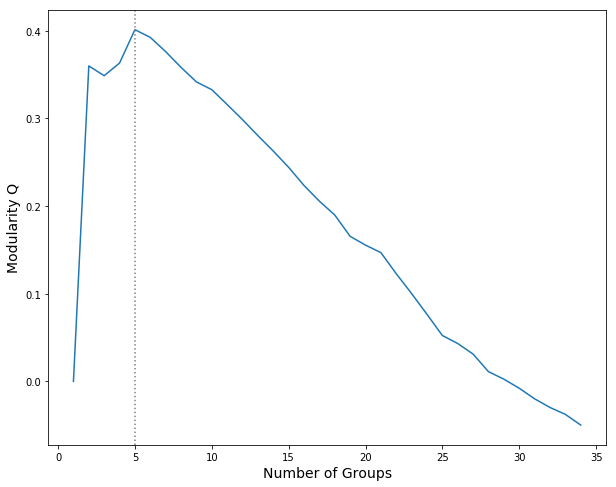

In [46]:
# We can now do several things.
# First let's use the modularity of each partition to guide our cluster selection
# loop over all partitions and work out the modularity. Start with a single community of zero modularity.
mod = [[1,0.0]]
# partition counter NB starts at two as first partition creates 2 groups.
idx = 2
for p in [c for c in gn]:
    mod.append([idx,nx.community.quality.modularity(g_karate,p)])
    idx +=1
mod = np.array(mod)

# Now graph modularity by partitions
f, ax = plt.subplots(figsize=(10, 8))
ax.plot(mod[:,0],mod[:,1])
ax.set_xlabel('Number of Groups', fontsize = 14)
ax.set_ylabel('Modularity Q', fontsize = 14)

# Add a vertical line to denote largest value
ax.axvline(5, c='0.5', ls=':');

In [7]:
# We can see that Modularity is maximised for 5 groups.
# Let's get the 5 group partitioning as a dictionary
gn = nx.community.girvan_newman(g_karate)
gn = {idx: gn for idx, gn in enumerate([c for c in gn][3])}
# Assign group ids to node ids as dict
attr = {n: gn for gn, nodes in gn.items() for n in nodes}
# Finally, assign to nodes
nx.set_node_attributes(g_karate, attr, "group")

In [16]:
# number of communities and their sizes
[{i: len(j)} for i, j in gn.items()]

[{0: 10}, {1: 6}, {2: 5}, {3: 12}, {4: 1}]

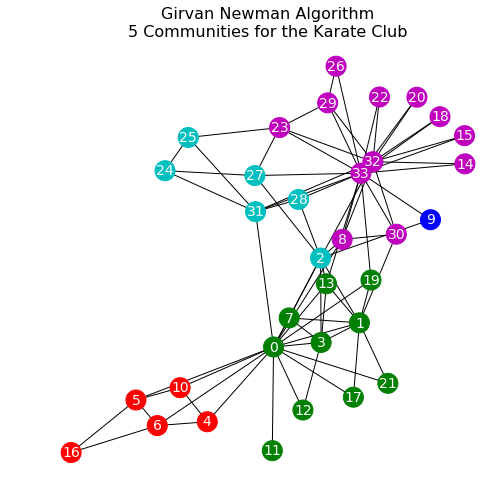

In [8]:
# Now plot with groups coloured
# First create a colour mapping
c = {0: 'g', 1:'c', 2:'r', 3:'m', 4:'b'}
f, ax = plt.subplots(figsize = (8,8))
nx.draw(g_karate, node_color =  np.apply_along_axis(lambda x: c[x[1]['group']],1,np.array(g_karate.nodes(data=True))),
        node_size = 400, with_labels = True, font_size = 14, font_color = 'w', ax=ax)
ax.set_title('Girvan Newman Algorithm\n5 Communities for the Karate Club', fontsize = 16);

In [59]:
# This function takes in a generator object from networkx (nx.community.girvan_newman(G))
# It returns a linkage array which can be visualised with scipy.cluster.hierarchy.dendrogram

def linkage(g):
    # Extract all items in the generator to a list of tuples of sets
    g = [c for c in gn]
    # reverse the list so we start from the bottom
    g.reverse()
    # list to hold the linkage
    Z = []
    # Starting id of agglomerated nodes
    idx = len(g) + 1
    # row index variable
    row_n = 0
    # dictionary for agglomerations of nodes
    agg_ids = {}
    # Now for each level in g, identify the agglomerated nodes and add to Z
    for row in g:
        if row_n == 0:
            row_n += 1
        else:
            # Compare current row to previous row until you find a difference
            same = True
            item = 0
            while same:
                # If the item in this row is the same as in the previous row, just increment the item
                if row[item] == g[row_n-1][item]:
                    item += 1
                # Otherwise record as an agglomeration
                else:
                    # If this is a new merge, just add to Z
                    if len(row[item]) == 2:
                        # [idx1, idx2, dist, sample_count]
                        nodes = tuple(row[item])
                        Z.append([nodes[0],nodes[1],1.0*row_n,2])
                        # Now add this agglomeration to the agg_ids dict
                        agg_ids[tuple(sorted(nodes))] = idx
                        # increment idx
                        idx += 1
                    else:
                        # This isn't a new merge, it has 3 or more nodes
                        # Get the previous agglomeration
                        nodes_prev = g[row_n-1][item]
                        # get current nodes
                        nodes_curr = row[item]
                        # Work out the original id(s) of the two sets
                        s1 = nodes_curr & nodes_prev
                        s2 = nodes_curr ^ nodes_prev
                        # If only one node was agglomerated, just add that to Z
                        if len(s1) == 1 or len(s2) == 1:
                            if len(s1) == 1:
                                agg_id = agg_ids[tuple(sorted(s2))]
                                Z.append([agg_id,list(s1)[0],1.0*row_n,len(nodes_curr)])
                                # Now add this agglomeration to the agg_ids dict
                                agg_ids[tuple(sorted(nodes_curr))] = idx
                                # increment idx
                                idx += 1
                            else:
                                agg_id = agg_ids[tuple(sorted(s1))]
                                Z.append([agg_id,list(s2)[0],1.0*row_n,len(nodes_curr)])
                                # Now add this agglomeration to the agg_ids dict
                                agg_ids[tuple(sorted(nodes_curr))] = idx
                                # increment idx
                                idx += 1
                        # If the neither is a single node, it means we're combining previously agglomerated nodes
                        else:
                            # get ids of join nodes
                            agg_id1 = agg_ids[tuple(sorted(s1))]
                            agg_id2 = agg_ids[tuple(sorted(s2))]
                            # Add to z
                            Z.append([agg_id1,agg_id2,1.0*row_n,len(nodes_curr)])
                            # Now add this agglomeration to the agg_ids dict
                            agg_ids[tuple(sorted(nodes_curr))] = idx
                            # increment idx
                            idx += 1
                    # End the loop
                    same = False
            row_n += 1
    # Before we return we need to add the final singleton cluster
    agg_id1 = agg_ids[tuple(sorted(g[-1][0]))]
    agg_id2 = agg_ids[tuple(sorted(g[-1][1]))]
    Z.append([agg_id1,agg_id2,1.0*row_n,len(g) + 1])
    # Make Z a Numpy Array
    Z = np.array(Z)
    return Z

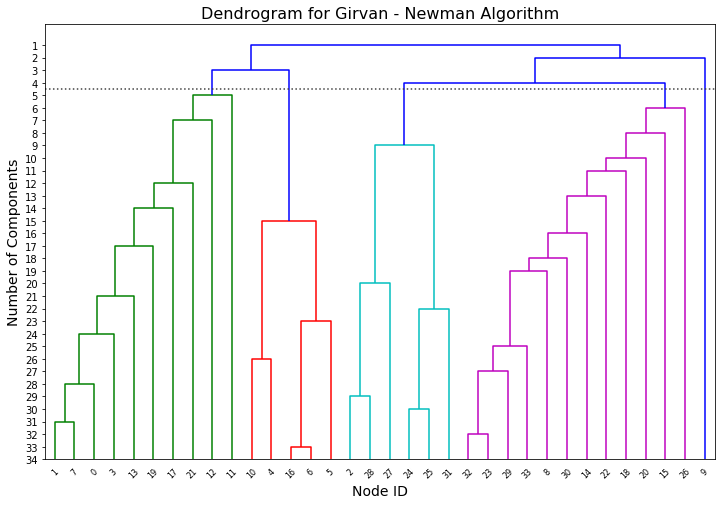

In [63]:
# We don't have to use the 5 group solution, we can actually cut the dendrogram anywhere.
f, ax1 = plt.subplots(figsize=(12, 8))

# Make a dendrogram that is stepped by number of subgraph
# Need to make the partitions again
gn = nx.community.girvan_newman(g_karate)
# Now create the linkage array
Z = linkage(gn)
# calculate full dendrogram
dendrogram(Z,color_threshold = 30, ax=ax1)
ax1.set_xlabel('Node ID', fontsize = 14)
# Adapt the y axis
ax1.set_yticks(range(0,len(Z)+1))
ax1.set_yticklabels(range(34,0,-1))
ax1.set_ylabel('Number of Components', fontsize=14)

# Put in a horizontal line for the optimum # of groups by modularity
ax1.axhline(y=len(Z)-3.5, c='0.25', ls=':')
ax1.set_title('Dendrogram for Girvan - Newman Algorithm', fontsize=16);

In [168]:
# NB The Girvan Newman method is based on computing betweenness in an iterative way, 
# hence it is extremely slow for large networks.

# Fast greedy modularity optimisation: Clauset - Newman - Moore

In [76]:
# This algorithm won't be available until networkx 2.2 unless you use 2.2rc now.
greedy = list(nx.community.greedy_modularity_communities(g_karate))

In [84]:
# Assign group ids to groups found by the fast greedy modularity algorithm.
groups = {i:j for i, j in enumerate(greedy)}
# Assign group ids to node ids as dict
attr = {n: gn for gn, nodes in groups.items() for n in nodes}
# Finally, assign to nodes
nx.set_node_attributes(g_karate, attr, "greedy")

In [85]:
# number of communities and their sizes
[{i: len(j)} for i, j in groups.items()]

[{0: 17}, {1: 9}, {2: 8}]

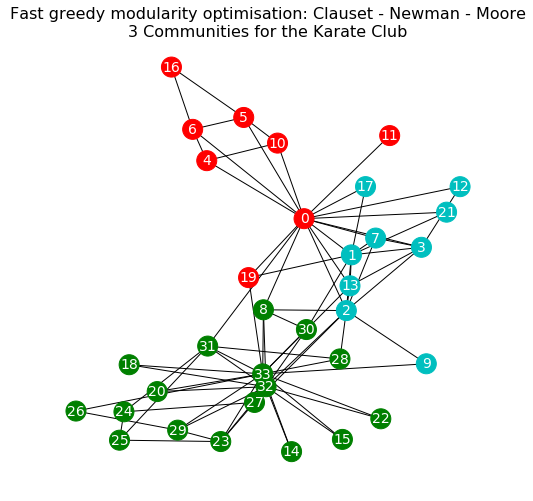

In [87]:
# Now plot with groups coloured
# First create a colour mapping
c = {0: 'g', 1:'c', 2:'r'}
f, ax = plt.subplots(figsize = (8,8))
nx.draw(g_karate, node_color =  np.apply_along_axis(lambda x: c[x[1]['greedy']],1,np.array(g_karate.nodes(data=True))),
        node_size = 400, with_labels = True, font_size = 14, font_color = 'w', ax=ax)
ax.set_title('Fast greedy modularity optimisation: Clauset - Newman - Moore\n3 Communities for the Karate Club', fontsize = 16);

In [89]:
# Unfortunately, this algorithm doesn't give me enough information to make a dendrogram.

# Community structure via short random walks: Pons & Latapy

In [92]:
# Not implemented

# Leading Eigenvector: Newman Spectral Approach

In [93]:
# Not implemented

# Louvain method: Blondel et al, modularity optimization

In [3]:
# To use this method, we need to import a separate library that uses networkx called python-louvain and imported as:
import community

In [4]:
# First compute the best partition
partition = community.best_partition(g_karate)
# Assign to nodes
nx.set_node_attributes(g_karate, partition, "louvain")

In [21]:
# Count nodes in each group
counts = {}
for i,j in partition.items():
    if j not in counts.keys():
        counts[j] = 1
    else:
        counts[j] += 1
counts

{0: 12, 1: 5, 2: 11, 3: 6}

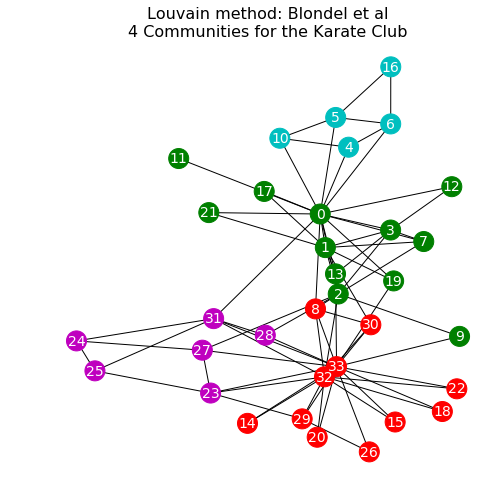

In [11]:
# Now plot with groups coloured
# First create a colour mapping
c = {0: 'g', 1:'c', 2:'r',3:'m'}
f, ax = plt.subplots(figsize = (8,8))
nx.draw(g_karate, node_color =  np.apply_along_axis(lambda x: c[x[1]['louvain']],1,np.array(g_karate.nodes(data=True))),
        node_size = 400, with_labels = True, font_size = 14, font_color = 'w', ax=ax)
ax.set_title('Louvain method: Blondel et al\n4 Communities for the Karate Club', fontsize = 16);

# Infomap method: Rosvall and Bergstrom

In [33]:
# Not implemented

# igraph

In [47]:
# Borrow the karate club network from networkx
ig_karate = ig.Graph.TupleList(g_karate.edges(), directed=False)
ig_karate.vs['club'] = list(nx.get_node_attributes(g_karate, 'club').values())

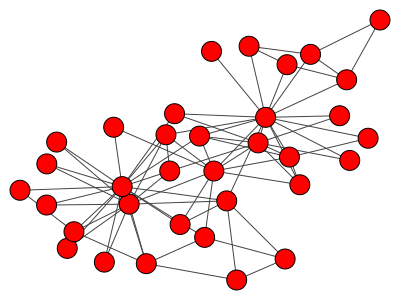

In [51]:
# basic plot
ig.plot(ig_karate, bbox = (400,300))

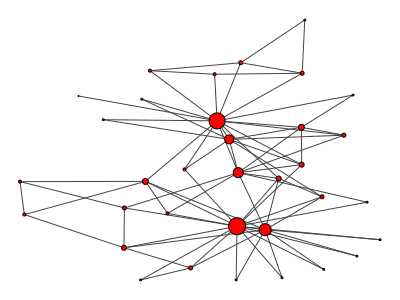

In [79]:
#let us now produce a plot such that the nodes in the plot have a size related to their degree
ig.plot(ig_karate, vertex_size = ig_karate.degree(), bbox = (400,300))

# Girvan - Newman algorithm

In [164]:
# As standard this returns the partitioning that maximises modularity
gn = ig_karate.community_edge_betweenness()

In [89]:
# number of communities and their sizes
print "number of communities:", gn.optimal_count

number of communities: 5


In [97]:
# Get count of group membership
[{i:len(c)} for i, c in enumerate(gn.as_clustering())]

[{0: 10}, {1: 6}, {2: 5}, {3: 12}, {4: 1}]

In [93]:
# Describe communities
print gn.as_clustering()

Clustering with 34 elements and 5 clusters
[0] 0, 1, 3, 7, 11, 12, 13, 17, 19, 21
[1] 2, 31, 27, 28, 25, 24
[2] 4, 5, 6, 10, 16
[3] 8, 30, 32, 33, 14, 15, 18, 20, 22, 23, 29, 26
[4] 9


In [165]:
# the process aims at maximising the modularity
gn.as_clustering().modularity

0.40129848783694944

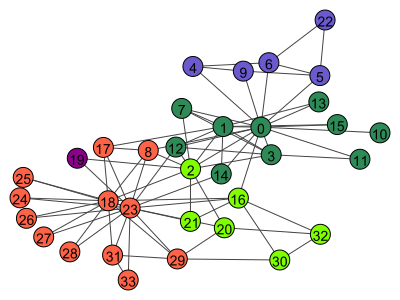

In [140]:
# Get membership vector and map to X11 colors
groups = gn.as_clustering().membership
colors = {0: 'Sea Green', 1: 'Chartreuse',2: 'Slate Blue', 3: 'Tomato', 4: 'Dark Magenta'}
cmap = [colors[c] for c in groups]
# Now plot with labels
ig_karate.vs["label"] = [v.index for v in ig_karate.vs()]
ig.plot(ig_karate,vertex_color = cmap, bbox =(400,300))

In [113]:
# The division depends on where in the hierarchical tree we put the cut.
# This methodology relies on cutting the tree in order to maximise modularity
# Let us look at this through the dendrogram
# The dendrograms are pretty basic in python-igraph
print gn

Dendrogram, 34 elements, 33 merges

16 30 32 2 21 20 8 17 18 23 31 29 28 27 26 25 24 33 19 0 1 3 12 7 15 14 13 11 10 5 6 22 4 9
|  |  |  | |  |  | |  |  |  |  |  |  |  |  |  |  |  |  | | | |  | |  |  |  |  |  | | |  | |
|  |  |  | |  |  | |  `--'  |  |  |  |  |  |  |  |  |  | | | |  | |  |  |  |  |  | | |  | |
|  |  |  | |  |  | |   |    |  |  |  |  |  |  |  |  |  | | | |  | |  |  |  |  |  | | |  | |
`--'  |  | |  |  | |   `----'  |  |  |  |  |  |  |  |  | | | |  | |  |  |  |  |  | | |  | |
 |    |  | |  |  | |     |     |  |  |  |  |  |  |  |  | | | |  | |  |  |  |  |  | | |  | |
 `----'  | |  |  | |     `-----'  |  |  |  |  |  |  |  | | | |  | |  |  |  |  |  | `-'  | |
   |     | |  |  | |        |     |  |  |  |  |  |  |  | | | |  | |  |  |  |  |  |  |   | |
   |     `-'  |  | |        |     |  |  |  |  |  |  |  | | `-'  | |  |  |  |  |  `--'   `-'
   |      |   |  | |        |     |  |  |  |  |  |  |  | |  |   | |  |  |  |  |   |      | 
   |      |   |  | |        |     |  |  |  |

# Fast greedy modularity optimisation: Clauset - Newman - Moore

In [142]:
greedy = ig_karate.community_fastgreedy()

In [144]:
# number of communities
print "number of communities:", greedy.optimal_count

number of communities: 3


In [145]:
# Get count of group membership
[{i:len(c)} for i, c in enumerate(greedy.as_clustering())]

[{0: 8}, {1: 9}, {2: 17}]

In [146]:
# Describe communities
print greedy.as_clustering()

Clustering with 34 elements and 3 clusters
[0] 0, 4, 5, 6, 10, 11, 19, 16
[1] 1, 2, 3, 7, 12, 13, 17, 21, 9
[2] 8, 31, 30, 32, 27, 28, 33, 14, 15, 18, 20, 22, 23, 25, 29, 24, 26


In [162]:
# the process aims at maximising the modularity
greedy.as_clustering().modularity

0.38067061143984215

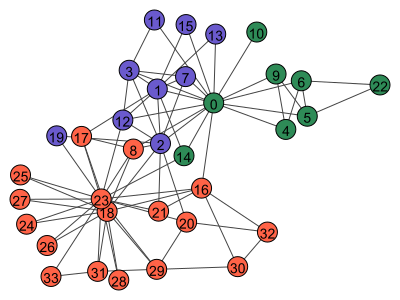

In [160]:
# Get membership vector and map to X11 colors
ggroups = greedy.as_clustering().membership
colors = {0: 'Sea Green', 1: 'Slate Blue', 2: 'Tomato'}
gcmap = [colors[c] for c in ggroups]

ig.plot(ig_karate,vertex_color = gcmap, bbox =(400,300))

In [166]:
# See the dendrogram
print greedy

Dendrogram, 34 elements, 33 merges

26 27 8 17 18 24 32 30 16 21 31 33 23 29 20 25 28 7 3 11 19 2 12 1 13 15 22 5 6 0 4 9 10 14
|  |  | |  |  |  |  |  |  |  |  |  |  |  |  |  |  | | |  |  | |  | |  |  |  | | | | | |  |
|  |  | |  |  |  |  |  |  |  `--'  |  |  |  |  |  | | |  |  | |  | |  |  |  | | | | | |  |
|  |  | |  |  |  |  |  |  |   |    |  |  |  |  |  | | |  |  | |  | |  |  |  | | | | | |  |
|  |  | |  |  |  |  |  |  |   `----'  |  |  |  |  | | |  |  | |  | |  |  |  | | | | | |  |
|  |  | |  |  |  |  |  |  |     |     |  |  |  |  | | |  |  | |  | |  |  |  | | | | | |  |
|  |  | |  |  |  |  |  |  |     `-----'  |  |  |  | | |  |  | |  | |  |  |  | | | | | |  |
|  |  | |  |  |  |  |  |  |        |     |  |  |  | | |  |  | |  | |  |  |  | | | | | |  |
|  |  | |  |  |  |  |  |  |        `-----'  |  |  | | |  |  | |  | |  |  `--' | | | | |  |
|  |  | |  |  |  |  |  |  |           |     |  |  | | |  |  | |  | |  |   |   | | | | |  |
|  |  | |  |  |  |  |  |  |           |     |  |  | |

# Community structure via short random walks: Pons & Latapy

In [167]:
walk = ig_karate.community_walktrap()

In [168]:
# number of communities
print "number of communities:", walk.optimal_count

number of communities: 5


In [169]:
# Get count of group membership
[{i:len(c)} for i, c in enumerate(walk.as_clustering())]

[{0: 9}, {1: 7}, {2: 5}, {3: 9}, {4: 4}]

In [170]:
# Describe communities
print walk.as_clustering()

Clustering with 34 elements and 5 clusters
[0] 0, 1, 3, 7, 11, 12, 17, 19, 21
[1] 2, 8, 13, 31, 30, 9, 28
[2] 4, 5, 6, 10, 16
[3] 32, 33, 14, 15, 18, 20, 22, 29, 26
[4] 27, 23, 25, 24


In [171]:
# the process aims at maximising the modularity
walk.as_clustering().modularity

0.3532215647600263

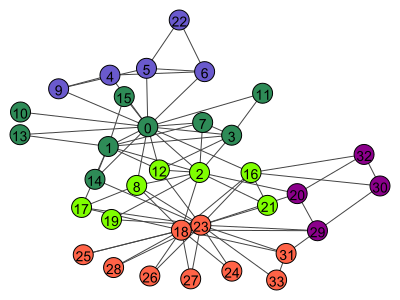

In [172]:
# Get membership vector and map to X11 colors
wgroups = walk.as_clustering().membership
colors = {0: 'Sea Green', 1: 'Chartreuse',2: 'Slate Blue', 3: 'Tomato', 4: 'Dark Magenta'}
wcmap = [colors[c] for c in wgroups]

ig.plot(ig_karate,vertex_color = wcmap, bbox =(400,300))

In [173]:
print walk

Dendrogram, 34 elements, 33 merges

14 0 7 3 1 13 15 11 10 9 4 6 5 22 12 2 19 17 8 21 16 23 18 24 25 26 27 28 33 31 29 20 32 30
|  | | | | |  |  |  |  | | | | |  |  | |  |  | |  |  |  |  |  |  |  |  |  |  |  |  |  |  |
|  | `-' | |  |  |  |  `-' `-' |  |  | |  `--' |  |  `--'  |  |  |  |  |  `--'  |  |  `--'
|  |  |  | |  |  |  |   |   |  |  |  | |   |   |  |   |    |  |  |  |  |   |    |  |   |  
|  |  `--' |  |  |  |   |   |  |  `--' |   |   |  |   `----'  |  |  |  |   |    |  |   |  
|  |   |   |  |  |  |   |   |  |   |   |   |   |  |     |     |  |  |  |   |    |  |   |  
|  |   |   |  |  |  |   |   |  |   |   |   |   |  |     `-----'  |  |  |   |    |  |   |  
|  |   |   |  |  |  |   |   |  |   |   |   |   |  |        |     |  |  |   |    |  |   |  
|  |   |   |  |  |  |   |   |  |   |   |   |   |  |        `-----'  |  |   |    |  |   |  
|  |   |   |  |  |  |   |   |  |   |   |   |   |  |           |     |  |   |    |  |   |  
|  |   |   |  |  |  |   |   |  |   |   |   |   |  |  

# Leading eigenvector: Newman spectral approach

In [174]:
spectral = ig_karate.community_leading_eigenvector()

In [178]:
# number of communities
print "number of communities:", len(spectral.sizes())

number of communities: 4


In [188]:
# Get count of group membership
[{i:len(c)} for i, c in enumerate(spectral.as_cover())]

[{0: 7}, {1: 12}, {2: 9}, {3: 6}]

In [226]:
# Describe communities
print spectral

Clustering with 34 elements and 4 clusters
[0] 0, 4, 5, 6, 10, 11, 16
[1] 8, 30, 32, 9, 33, 14, 15, 18, 20, 22, 29, 26
[2] 1, 2, 3, 7, 12, 13, 17, 19, 21
[3] 31, 27, 28, 23, 25, 24


In [192]:
#the process aims at maximising the modularity
spectral.modularity

0.3934089414858645

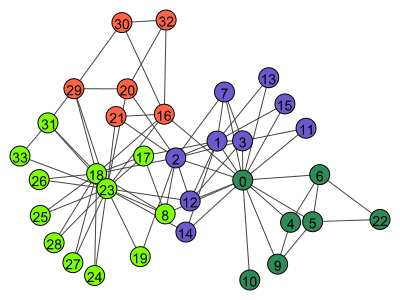

In [193]:
# Get membership vector and map to X11 colors
sgroups = spectral.membership
colors = {0: 'Sea Green', 1: 'Chartreuse',2: 'Slate Blue', 3: 'Tomato'}
scmap = [colors[c] for c in sgroups]

ig.plot(ig_karate,vertex_color = scmap, bbox =(400,300))
# NB no dendrogram for this method

# Louvain method: Blondel et al, modularity optimization

In [195]:
louvain = ig_karate.community_multilevel()

In [199]:
# number of communities
print "number of communities:", len(louvain.sizes())

number of communities: 4


In [200]:
# Get count of group membership
[{i:len(c)} for i, c in enumerate(louvain.as_cover())]

[{0: 12}, {1: 5}, {2: 6}, {3: 11}]

In [225]:
# Describe communities
print louvain

Clustering with 34 elements and 4 clusters
[0] 0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21, 9
[1] 4, 5, 6, 10, 16
[2] 31, 27, 28, 23, 25, 24
[3] 8, 30, 32, 33, 14, 15, 18, 20, 22, 29, 26


In [202]:
#the process aims at maximising the modularity
louvain.modularity

0.41880341880341887

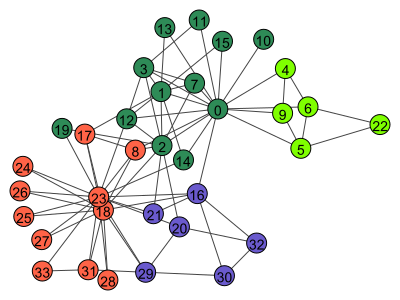

In [220]:
# Get membership vector and map to X11 colors
sgroups = louvain.membership
colors = {0: 'Sea Green', 1: 'Chartreuse',2: 'Slate Blue', 3: 'Tomato'}
scmap = [colors[c] for c in sgroups]

ig.plot(ig_karate,vertex_color = scmap, bbox =(400,300))
# NB no dendrogram for this method

# Infomap method: Rosvall and Bergstrom

In [222]:
infomap = ig_karate.community_infomap()

In [223]:
# number of communities
print "number of communities:", len(infomap.sizes())

number of communities: 3


In [224]:
# Get count of group membership
[{i:len(c)} for i, c in enumerate(infomap.as_cover())]

[{0: 17}, {1: 12}, {2: 5}]

In [227]:
# Describe communities
print infomap

Clustering with 34 elements and 3 clusters
[0] 8, 31, 30, 32, 27, 28, 33, 14, 15, 18, 20, 22, 23, 25, 29, 24, 26
[1] 0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21, 9
[2] 4, 5, 6, 10, 16


In [228]:
#the process aims at maximising the modularity
infomap.modularity

0.4020381328073636

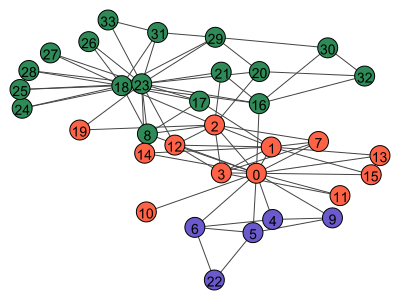

In [229]:
# Get membership vector and map to X11 colors
igroups = infomap.membership
colors = {0: 'Sea Green', 1: 'Tomato',2: 'Slate Blue'}
icmap = [colors[c] for c in igroups]

ig.plot(ig_karate,vertex_color = icmap, bbox =(400,300))
# NB no dendrogram for this method